In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/huggingface-bert-variants/bert-large-uncased/bert-large-uncased/config.json
/kaggle/input/huggingface-bert-variants/bert-large-uncased/bert-large-uncased/tokenizer.json
/kaggle/input/huggingface-bert-variants/bert-large-uncased/bert-large-uncased/tf_model.h5
/kaggle/input/huggingface-bert-variants/bert-large-uncased/bert-large-uncased/tokenizer_config.json
/kaggle/input/huggingface-bert-variants/bert-large-uncased/bert-large-uncased/pytorch_model.bin
/kaggle/input/huggingface-bert-variants/bert-large-uncased/bert-large-uncased/vocab.txt
/kaggle/input/huggingface-bert-variants/bert-large-uncased/bert-large-uncased/flax_model.msgpack
/kaggle/input/huggingface-bert-variants/bert-large-uncased/bert-large-uncased/whole-word-masking/._bert_config.json
/kaggle/input/huggingface-bert-variants/bert-large-uncased/bert-large-uncased/whole-word-masking/bert_config.json
/kaggle/input/huggingface-bert-variants/bert-large-uncased/bert-large-uncased/whole-word-masking/pytorch_model.bin
/

In [2]:
import numpy as np
import pandas as pd

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style='darkgrid', font_scale=1)

train_df = pd.read_csv('/kaggle/input/feedback-prize-english-language-learning/train.csv')
test_df = pd.read_csv('/kaggle/input/feedback-prize-english-language-learning/test.csv')
sample_df = pd.read_csv('/kaggle/input/feedback-prize-english-language-learning/sample_submission.csv')

# Checking for null values
train_df.isnull().sum() ,train_df.shape

(text_id        0
 full_text      0
 cohesion       0
 syntax         0
 vocabulary     0
 phraseology    0
 grammar        0
 conventions    0
 dtype: int64,
 (3911, 8))

In [4]:
bert_path = '../input/huggingface-bert-variants/bert-base-uncased/bert-base-uncased'



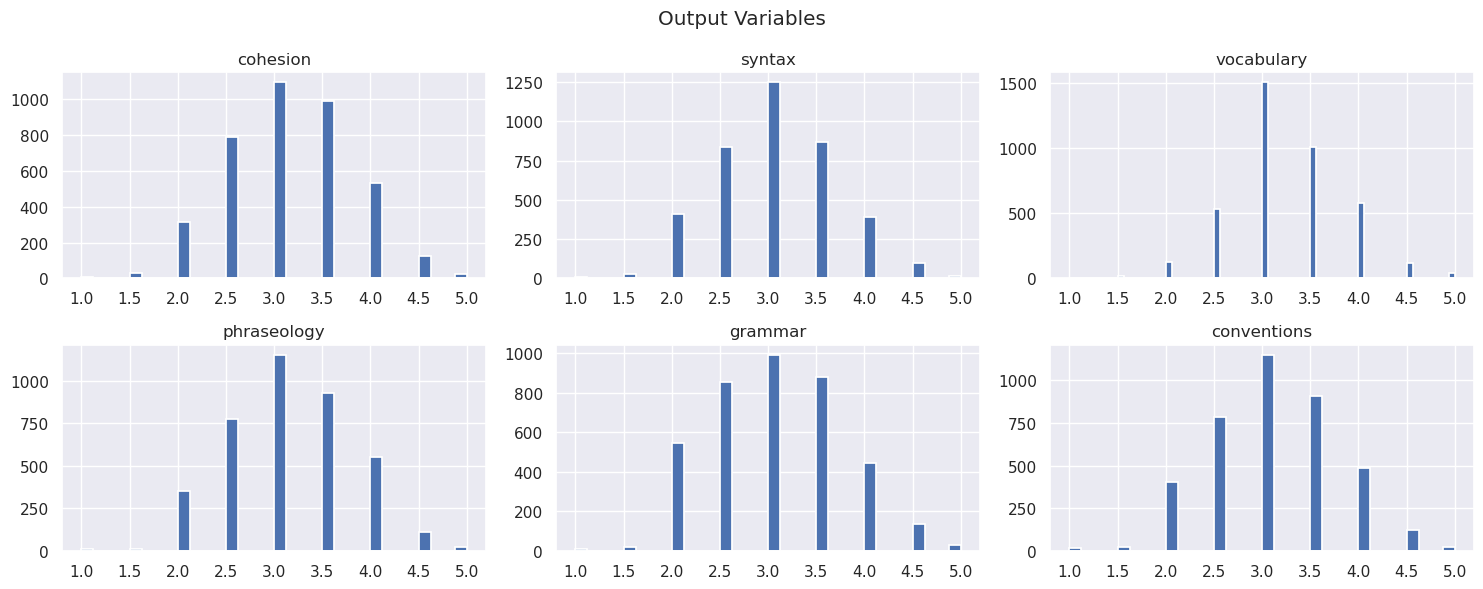

In [5]:
targets = ['cohesion', 'syntax', 'vocabulary', 'phraseology', 'grammar', 'conventions']

fig, axes = plt.subplots(2, len(targets)//2, figsize=(15,6))

for i, target in enumerate(targets):
    ax = axes.flat[i]
    sns.histplot(x=target, data=train_df, linewidth=1.25, alpha=1, ax=ax, zorder=2)
    ax.set_title(target)
    ax.set(xlabel=None, ylabel=None)
    
fig.suptitle('Output Variables')
plt.tight_layout()
plt.show()

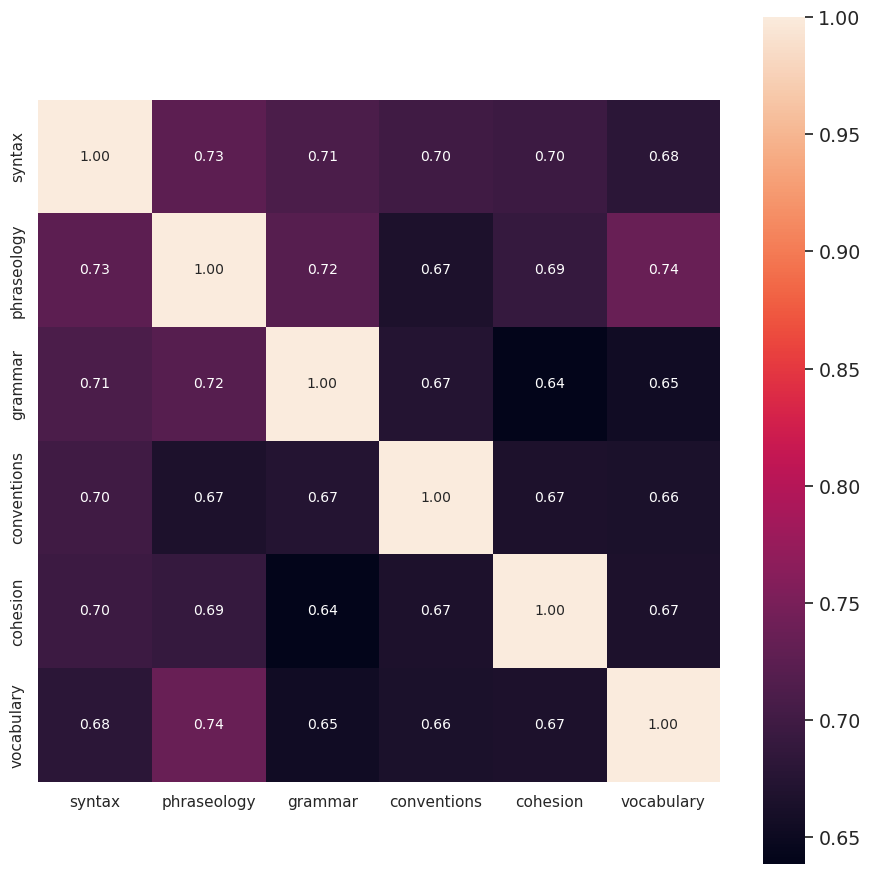

Index(['syntax', 'phraseology', 'grammar', 'conventions', 'vocabulary'], dtype='object')

In [6]:
k = len(train_df.columns) #number of variables for heatmap
f,ax = plt.subplots(figsize=(11, 11))
cols = train_df.corr().abs().nlargest(k, 'syntax')['syntax'].index
cm = np.corrcoef(train_df[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()
cols = cols.drop('cohesion')
cols

In [7]:
# Merging Train and Test Data
ntrain = train_df.shape[0]
ntest = test_df.shape[0]
all_data = pd.concat((train_df, test_df)).reset_index(drop=True)
all_data.drop(['text_id'], axis=1, inplace=True)
print("all_data size is : {}".format(all_data.shape))


all_data size is : (3914, 7)


In [8]:
import string
from nltk.corpus import stopwords
PUNCT_TO_REMOVE = string.punctuation
STOPWORDS = set(stopwords.words('english'))
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
import re

# Create an instance of a PorterStemmer object
lemmatizer = WordNetLemmatizer()

def preprocess(text) : 
    #Using cased model so not lowering 
    text = text.lower()
    text = re.sub(r'https?://\S+|www\.\S+','', text)
    text = re.sub(r'@[0-9a-zA-Z]*\W+',' ' , text)
    #text = re.sub(r'\.','[SEP]' , text)
    
    #text = re.sub(r'\W+', ' ', text)
    text = re.sub(r'\d+', ' ', text)
    text = re.sub(r'\#', ' ', text)
    text = re.sub(r'\'', ' ', text)
        
    #text = text.translate(str.maketrans('', '', PUNCT_TO_REMOVE))
    #text = [word for word in str(text).split() if word not in STOPWORDS]

    # For each token of each text, we generated its stem 
    #text = [lemmatizer.lemmatize(token) for token in text]
    #text = ' '.join(text)
    list_text = text.split()
    text = ' '.join(list_text[:512])
    return text

In [9]:
test = 'Our \'fffff\'Deeds are the . Reason of @insta this #earthquake M'
print(preprocess(test))

our fffff deeds are the . reason of this earthquake m


In [10]:
all_data['full_text'] = all_data['full_text'].apply(lambda text : preprocess(text))



In [11]:
train_data = all_data[:ntrain].copy()
test_data = all_data[ntrain:]

train_data.shape , test_data.shape

((3911, 7), (3, 7))

In [12]:
BATCH_SIZE = 6

MAX_LEN = max(len(x.split()) for x in all_data['full_text'])
print(MAX_LEN)

512


In [13]:
import tensorflow as tf
from transformers import BertTokenizer , TFBertModel 

AUTO = tf.data.experimental.AUTOTUNE

In [14]:
tokenizer = BertTokenizer.from_pretrained(bert_path)


In [15]:
def encode(input_text):
    inputs = tokenizer.batch_encode_plus(input_text,padding='max_length',max_length=MAX_LEN, truncation=True)
    return inputs

In [16]:
train_input = encode(train_data['full_text'].values.tolist())['input_ids']

train_data_ds = (
    tf.data.Dataset
    .from_tensor_slices((train_input,train_data.drop('full_text', axis = 1)))
    .repeat()
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

In [17]:
testing_input = encode(test_data.full_text.values.tolist())['input_ids']

test_dataset = (
    tf.data.Dataset
    .from_tensor_slices(testing_input)
    .batch(BATCH_SIZE)
)

In [18]:
# Custom error function MCRMSE : column wise root mean squared eoor
def MCRMSE(y_true, y_pred):
    colwise_mse = tf.reduce_mean(tf.square(y_true - y_pred), axis=1)
    return tf.reduce_mean(tf.sqrt(colwise_mse), axis=-1, keepdims=True)

In [19]:
def create_model():
    bert_encoder = TFBertModel.from_pretrained(bert_path )
    input_word_ids = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32, name="input_word_ids")

    embedding = bert_encoder(input_word_ids)[0]
    x = tf.keras.layers.GlobalAveragePooling1D()(embedding)
    x = tf.keras.layers.LayerNormalization()(x)
    #Output layer without activation function because regression task
    output = tf.keras.layers.Dense(6,)(x)

    model = tf.keras.models.Model(inputs=input_word_ids, outputs=output)
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss=MCRMSE
                  , metrics=['accuracy', MCRMSE])
    return model

In [20]:
model= create_model()
model.summary()

Some layers from the model checkpoint at ../input/huggingface-bert-variants/bert-base-uncased/bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at ../input/huggingface-bert-variants/bert-base-uncased/bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_word_ids (InputLayer)  [(None, 512)]            0         
                                                                 
 tf_bert_model (TFBertModel)  TFBaseModelOutputWithPoo  109482240
                             lingAndCrossAttentions(l            
                             ast_hidden_state=(None,             
                             512, 768),                          
                              pooler_output=(None, 76            
                             8),                                 
                              past_key_values=None, h            
                             idden_states=None, atten            
                             tions=None, cross_attent            
                             ions=None)                          
                                                             

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

callback = tf.keras.callbacks.EarlyStopping(monitor='MCRMSE', patience = 2 ,restore_best_weights=True)

history = model.fit(
                    train_data_ds, 
                    steps_per_epoch= train_data.shape[0]//BATCH_SIZE,
                    batch_size = BATCH_SIZE,
                    epochs= 25,
                    verbose = 1,
                    shuffle= True,
                    callbacks=[callback],
                       )

Epoch 1/25
651/651 [==============================] - 333s 445ms/step - loss: 0.5099 - accuracy: 0.2192 - MCRMSE: 0.5099
Epoch 2/25
651/651 [==============================] - 288s 442ms/step - loss: 0.4579 - accuracy: 0.2491 - MCRMSE: 0.4579
Epoch 3/25
651/651 [==============================] - 288s 442ms/step - loss: 0.4323 - accuracy: 0.2645 - MCRMSE: 0.4323
Epoch 4/25
651/651 [==============================] - 288s 442ms/step - loss: 0.4094 - accuracy: 0.2839 - MCRMSE: 0.4094
Epoch 5/25
651/651 [==============================] - 288s 442ms/step - loss: 0.3958 - accuracy: 0.2924 - MCRMSE: 0.3958
Epoch 6/25
651/651 [==============================] - 288s 442ms/step - loss: 0.3869 - accuracy: 0.3144 - MCRMSE: 0.3869
Epoch 7/25
651/651 [==============================] - 287s 441ms/step - loss: 0.3730 - accuracy: 0.3379 - MCRMSE: 0.3730
Epoch 8/25
651/651 [==============================] - 287s 440ms/step - loss: 0.3500 - accuracy: 0.3482 - MCRMSE: 0.3500
Epoch 9/25
651/651 [============